# Support Vector Regression
I'm following the guide here: <https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html>.

In [1]:
import glob
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Get Data

In [2]:
def get_subject_from_path(path):
    normalized_path = os.path.normpath(path)
    path_components = normalized_path.split(os.sep)
    return path_components[-2][4:]

In [3]:
# Search for all functional connectivity files and read them into a
# numpy array.
fc_path = '/imaging3/owenlab/bpho/python_power_fc'
fc_paths = glob.glob(fc_path + '/**/power_fc.npy', recursive=True)

fcs = {}
for path in fc_paths:
    subject_id = get_subject_from_path(path)
    # print(subject_id)
    subject_fc = np.load(path)
    fcs[subject_id] = subject_fc[np.triu_indices(264, k=1)]
print("Number of functional connectivities:", len(fcs))

Number of functional connectivities: 722


In [4]:
print("Number of features (connections):", fcs["NDARAP912JK3"].shape[0])

Number of features (connections): 34716


## Get Labels

In [5]:
wisc_label_path = "/imaging3/owenlab/bpho/Biobank Labels/Subjects with WISC.csv"
wisc_labels = pd.read_csv(wisc_label_path)
wisc_labels.set_index(keys='assessment WISC,EID', inplace=True)
display(wisc_labels)

,"assessment WISC,Administration","assessment WISC,Comment_ID","assessment WISC,Data_entry","assessment WISC,Days_Baseline","assessment WISC,PSCID","assessment WISC,START_DATE","assessment WISC,Season","assessment WISC,Site","assessment WISC,Study","assessment WISC,Visit_label",...,"assessment WISC,WISC_VSI_Sum","assessment WISC,WISC_Vocab_Raw","assessment WISC,WISC_Vocab_Scaled","assessment WISC,WISC_WMI","assessment WISC,WISC_WMI_Percentile","assessment WISC,WISC_WMI_Sum","assessment WISC,WISC_complete","assessment WISC,WISC_incomplete_reason","assessment WISC,Year","assessment Basic_Demos,Age"
"assessment WISC,EID",,,,,,,,,,,,,,,,,,,,,
NDARAC331VEH,All,NaN,Complete,2,NaN,1901-01-01T07:00:00Z,Spring,3,HBN,NaN,...,30,40,13,110,75.0,23,1,NaN,2019,14.167351
NDARAC462DZH,All,NaN,Complete,74,NaN,1901-01-01T07:00:00Z,Spring,1,HBN,NaN,...,9,18,10,76,5.0,12,1,NaN,2019,7.957449
NDARAF440XWG,All,NaN,Complete,104,NaN,1901-01-01T07:00:00Z,Spring,3,HBN,NaN,...,27,15,9,110,75.0,23,1,NaN,2019,7.253593
NDARAF535XK6,All,NaN,Complete,77,NaN,1901-01-01T07:00:00Z,Spring,3,HBN,NaN,...,13,18,4,97,42.0,19,1,NaN,2019,13.121492
NDARAG115LZP,All,NaN,Complete,135,NaN,1901-01-01T07:00:00Z,Spring,3,HBN,NaN,...,29,32,9,91,27.0,17,1,NaN,2018,14.167351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NDARPL406KX4,All,NaN,Complete,522,NaN,1901-01-01T07:00:00Z,Fall,1,HBN,NaN,...,18,16,7,88,21.0,16,1,NaN,2018,8.672370
NDARRL426AD5,All,NaN,Complete,119,NaN,1901-01-01T07:00:00Z,Fall,1,HBN,NaN,...,13,25,9,91,27.0,17,1,NaN,2018,11.234998
NDARTT272WT5,All,NaN,Complete,385,NaN,1901-01-01T07:00:00Z,Summer,1,HBN,NaN,...,21,34,11,100,50.0,20,1,NaN,2019,12.537759


In [6]:
label_subject_ids = wisc_labels.index
subject_ages = wisc_labels["assessment Basic_Demos,Age"].to_numpy()
subjects_with_wisc = {}

for subject_id in label_subject_ids:
    if subject_id not in fcs:
        continue
    
    subject_wisc_fsiq_sum = wisc_labels.at[subject_id, 'assessment WISC,WISC_FSIQ_Sum']
    subjects_with_wisc[subject_id] = (fcs[subject_id], subject_wisc_fsiq_sum)

print(subjects_with_wisc['NDARAC331VEH'])

(array([ 0.58186466, -0.05859981,  0.08431777, ...,  0.39561737,
        0.3742862 ,  0.6218255 ], dtype=float32), 89)


In [7]:
fc_matrices = []
wisc_measure = []

for features in subjects_with_wisc.values():
    fc_matrices.append(features[0])
    wisc_measure.append(features[1])

X = np.array(fc_matrices)
y = np.array(wisc_measure)

print("X shape:", X.shape, "y shape:", y.shape)

X shape: (425, 34716) y shape: (425,)


## Train Support Vector Regression (SVR)

In [8]:
from sklearn.svm import SVR
from sklearn.model_selection import KFold

kf = KFold(n_splits=10)

In [21]:
svr_rbf = SVR(kernel='rbf', C=1)
svr_lin = SVR(kernel='linear', C=1)
svr_poly = SVR(kernel='poly', C=1)

svrs = [svr_rbf, svr_lin, svr_poly]
kernel_label = ['RBF', 'Linear', 'Polynomial']
model_color = ['m', 'c', 'g']
model_scores = [[] for i in range(0, len(kernel_label))]

In [22]:
for index, svr in enumerate(svrs):
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        score = svr.fit(X_train, y_train).score(X_test, y_test)
        model_scores[index].append(score)

for index, scores in enumerate(model_scores):
    print(f"{kernel_label[index]} score: {np.mean(scores):.4f}")

RBF score: 0.0821
Linear score: -0.0530
Polynomial score: -0.0199


(425, 34716) (425,)


ValueError: x and y must be the same size

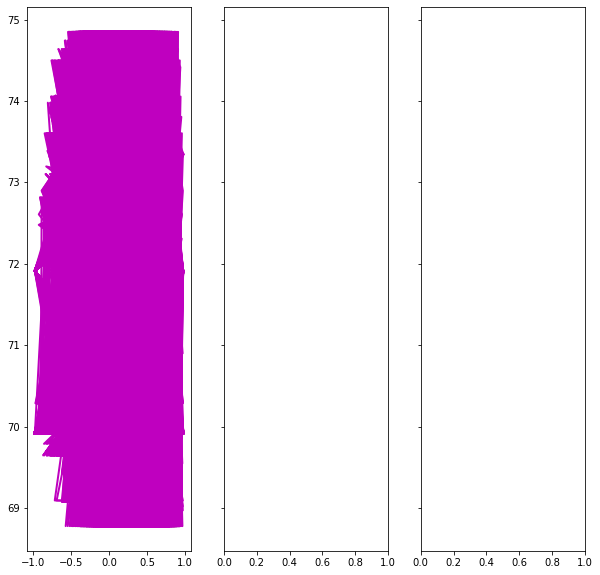

In [19]:
lw = 2

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 10), sharey=True)

for ix, svr in enumerate(svrs):
    y_pred = svr.fit(X, y).predict(X)
    print(X.shape, y_pred.shape)
    axes[ix].plot(X, y_pred, color=model_color[ix], lw=lw,
                  label='{} model'.format(kernel_label[ix]))
    
    axes[ix].scatter(X, y, facecolor="none",
                edgecolor=model_color[ix], s=50,
                label='{} support vectors'.format(kernel_label[ix]))
#     axes[ix].scatter(X[svr.support_], y[svr.support_], facecolor="none",
#                      edgecolor=model_color[ix], s=50,
#                      label='{} support vectors'.format(kernel_label[ix]))
#     axes[ix].scatter(X[np.setdiff1d(np.arange(len(X)), svr.support_)],
#                      y[np.setdiff1d(np.arange(len(X)), svr.support_)],
#                      facecolor="none", edgecolor="k", s=50,
#                      label='other training data')
#     axes[ix].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
#                     ncol=1, fancybox=True, shadow=True)

fig.text(0.5, 0.04, 'data', ha='center', va='center')
fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
fig.suptitle("Support Vector Regression", fontsize=14)
plt.show()